In [149]:
import pandas as pd
import numpy as np
import lightgbm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [113]:
# LIME for interpreting results
import lime 
import lime.lime_tabular

In [109]:
train_data=pd.read_csv('data/training_data.csv')

In [110]:
train_data.shape

(9461, 108)

In [164]:
features = train_data.drop(columns='ENERGY STAR Score')
targets = pd.DataFrame(train_data['ENERGY STAR Score'])
features = features.replace({np.inf: np.nan, -np.inf: np.nan})
train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size = 0.3, random_state = 42)

In [165]:
X=train_features.apply(lambda x: x.fillna(x.median()),axis=0).values
X_test=test_features.apply(lambda x: x.fillna(x.median()),axis=0).values

In [166]:
scaler = MinMaxScaler(feature_range=(0, 1))
#fitting and transform 
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [167]:
#converting into 1d array
y = train_labels.values.reshape((-1, ))
y_test = test_labels.values.reshape((-1, ))

In [168]:
import joblib
# load model
model = joblib.load('data/lgb.pkl')

In [169]:
model.fit(X, y)
pred = model.predict(X_test)

In [170]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [171]:
mae(y_test,pred)

8.819984968437407

In [172]:
results = pd.DataFrame({'Feature': list(train_features.columns), 
                                'Importance_value': model.feature_importances_})

# Show the top 10 most important
feature_results = results.sort_values('Importance_value', ascending = False).reset_index(drop=True)

feature_results.head(10)

,Feature,Importance_value
0,sqrt_Property Id,1247
1,sqrt_Source EUI (kBtu/ft²),1177
2,sqrt_Year Built,837
3,sqrt_Weather Normalized Site Electricity Inten...,700
4,sqrt_Site EUI (kBtu/ft²),651
5,sqrt_Order,634
6,sqrt_DOF Gross Floor Area,544
7,sqrt_Water Intensity (All Water Sources) (gal/...,515
8,sqrt_Weather Normalized Source EUI (kBtu/ft²),499
9,sqrt_Latitude,494


In [175]:
# Top most important features
important_features = feature_results['Feature'][:40]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in important_features]

# selecting only the most important features
X_imp = X[:, indices]
X_test_imp = X_test[:, indices]

print('Important training features shape: ', X_imp.shape)
print('Important testing  features shape: ', X_test_imp.shape)

Important training features shape:  (6622, 40)
Important testing  features shape:  (2839, 40)


Use the lgbregressor model to predict for important features

In [178]:
model.fit(X_imp, y)
pred_imp = model.predict(X_test_imp)

In [179]:
mape=np.mean(abs(y_test-pred_imp)/y_test)
mape

0.44234862395854263

we can see the accuracy for model after getting important features

In [188]:
accuracy=100*(1-mape)
print('accuracy for model with important features is {}'.format(accuracy))

accuracy for model with important features is 55.76513760414574


In [180]:
# Find the residuals
residuals = abs(pred_imp - y_test)
    
# Exact the worst and best prediction
wrong = X_test_imp[np.argmax(residuals), :]
correct = X_test_imp[np.argmin(residuals), :]

In [181]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_imp, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(important_features))

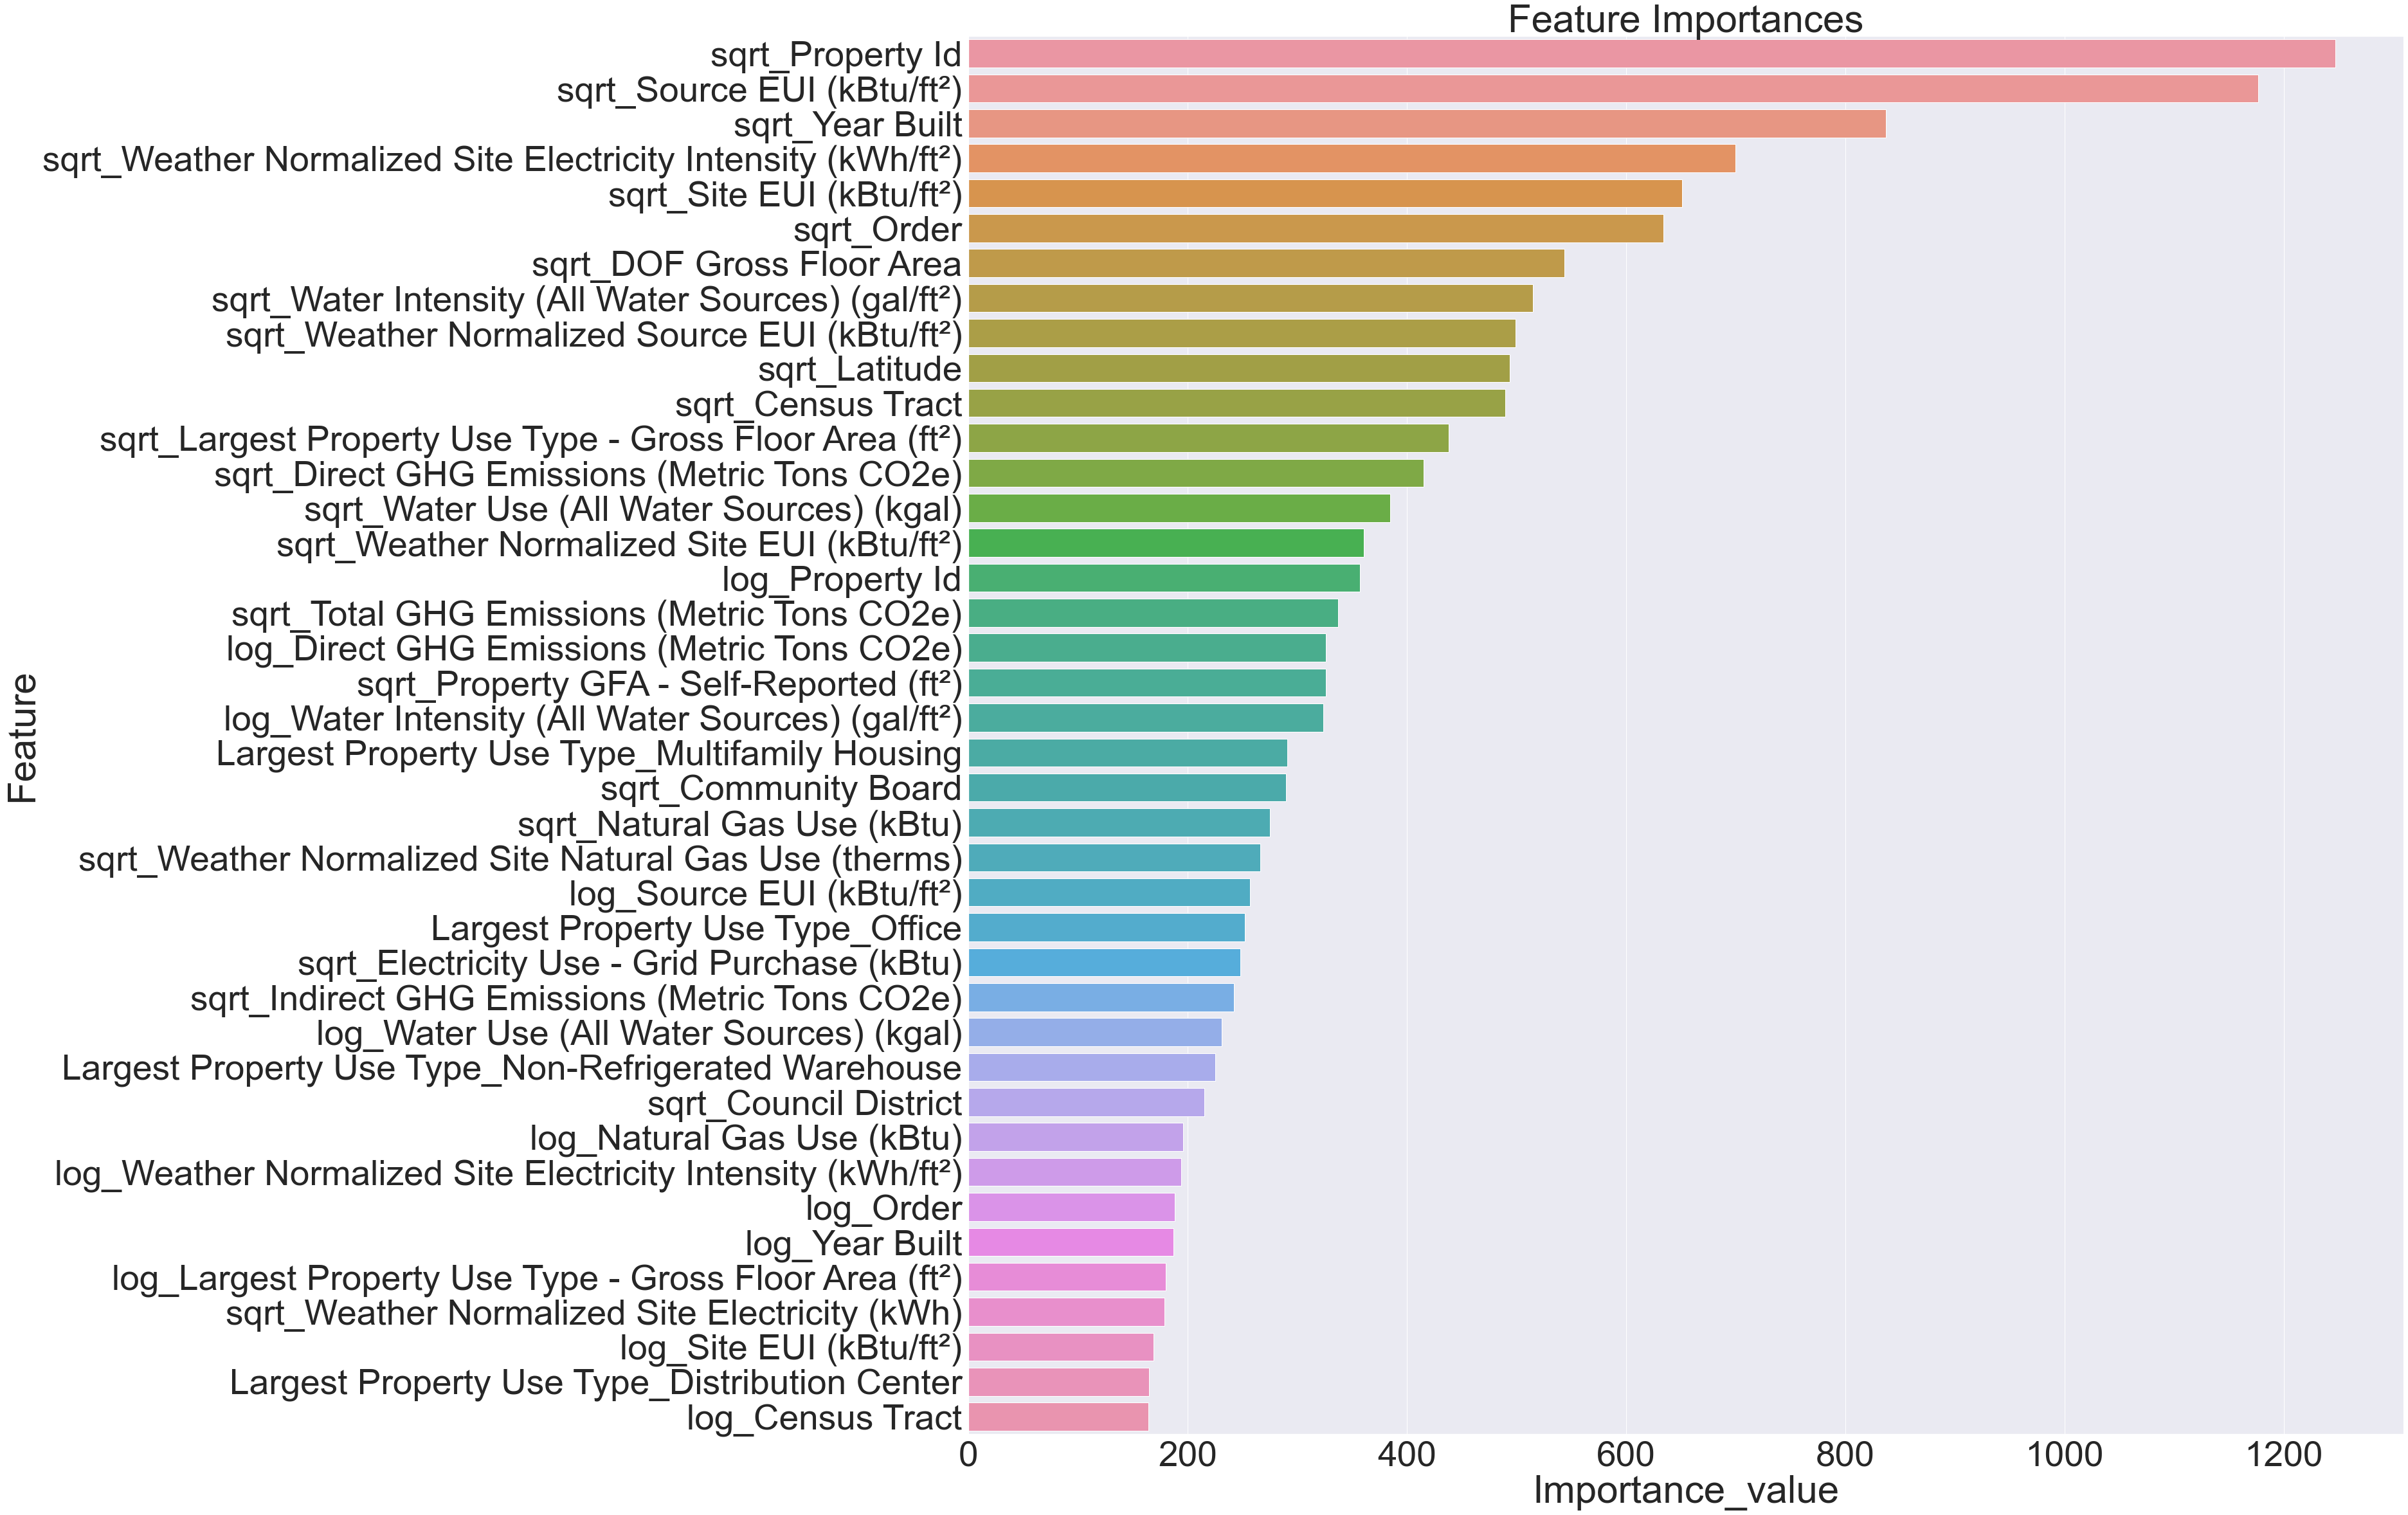

In [182]:
plt.figure(figsize=(40, 40))
sns.barplot(x="Importance_value", y="Feature", data=results.sort_values(by="Importance_value", 
                                                        ascending=False)[0:40])
sns.set(font_scale = 5)
plt.title('Feature Importances')
plt.savefig('feature_importances.png')
plt.show()

In [184]:
print('Predicted Value: %0.4f' % model.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])
print('Predicted Value: %0.4f' % model.predict(correct.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

Predicted Value: 17.4210
Actual Value: 96.0000
Predicted Value: 35.0031
Actual Value: 35.0000


C:\Users\Admin\Anaconda3\lib\site-packages\lightgbm\basic.py:253: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\Admin\Anaconda3\lib\site-packages\lightgbm\basic.py:253: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


In [ ]:
We still need to understand about the features which are important and hyperparameter tuning as well